# E-Mini S&P500先物の日足データ分析

まずは
- 可視化
- TDWを調べる

In [32]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
import locale

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
df = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5729 non-null   object 
 1   Time    5729 non-null   object 
 2   Open    5729 non-null   float64
 3   High    5729 non-null   float64
 4   Low     5729 non-null   float64
 5   Close   5729 non-null   float64
 6   Vol     5729 non-null   int64  
 7   OI      5729 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 358.2+ KB


In [3]:
df.head()

,Date,Time,Open,High,Low,Close,Vol,OI
0,09/11/1997,17:00,1071.25,1082.25,1062.75,1068.50,11825,2909
1,09/12/1997,17:00,1070.50,1089.00,1066.00,1071.25,9759,4059
2,09/15/1997,17:00,1086.00,1092.25,1081.50,1083.75,8551,3818
3,09/16/1997,17:00,1083.75,1112.50,1082.75,1108.50,11749,5314
4,09/17/1997,17:00,1108.50,1115.00,1104.00,1108.50,10849,5516


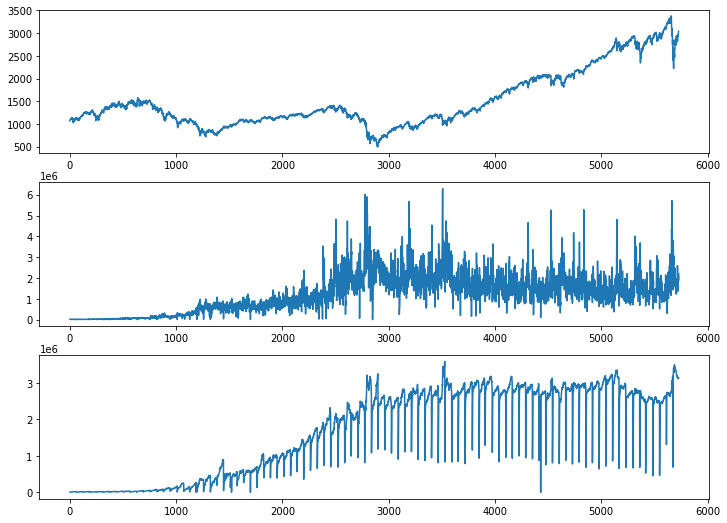

In [4]:
# 終値、出来高、建玉を可視化
fig, axs = plt.subplots(3, 1, figsize=(12, 9))
axs[0].plot(df['Close'])
axs[1].plot(df['Vol'])
axs[2].plot(df['OI'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 <a list of 100 Text major ticklabel objects>)

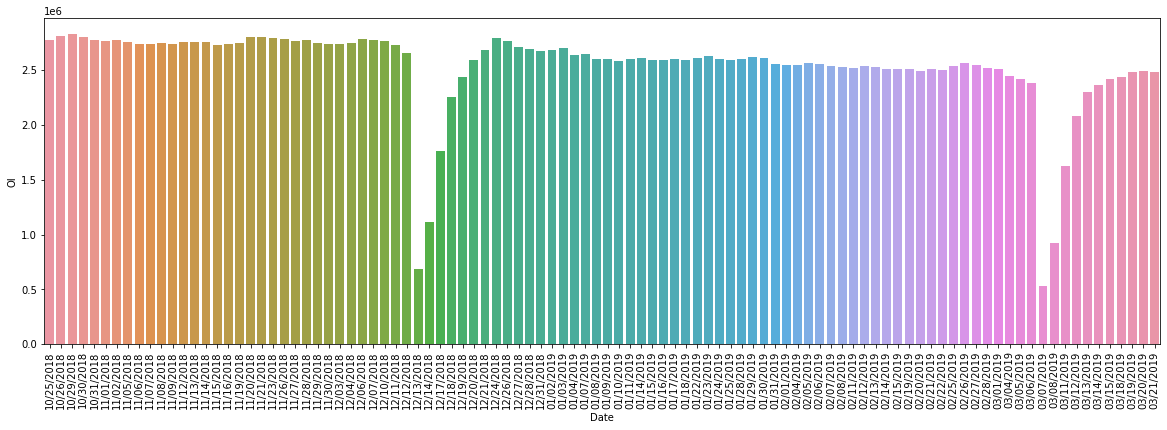

In [5]:
# Open Interest（建玉）が大きく減少するパターンが見られるので詳細を可視化
# 大体限月最終日の1～2週間前に発生しているから、おそらくロールオーバーと関係があるはず
# しかしロールオーバーの仕組みは、今の限月より次の限月の建玉が上回ったら、というルールだから、ロールオーバーしたところで建玉が大きく減るのはおかしい。
# だからロールオーバーした日ということではないはずだ。
# あるいは、トレーダーたちが大体似たようなルール（結果的に限月最終日の１～２週間前）で限月を切り替えるために、その日に急激に今の限月の建玉が減るということなのかもしれない。
# 結果としてその数日後に価格チャートがロールオーバーされるのかもしれない。
fig = plt.figure(figsize=(20, 6))
ax = sns.barplot('Date', 'OI', data=df[-400:-300])
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.xticks(rotation=90)

# TDWを調べる
- 全データでの検証
- 昔と今とで傾向が変わっているか確かめるため、一定年間での移動平均を取って可視化してみる

### 結果
- どの曜日も期待値はプラスで、上昇日の割合も0.5を超えている
- 期待値は特に大きいのは火曜日で、水木も比較的大きい
- 上昇日の割合は水木が大きい
- 一定年間の移動平均をとったところ、10年移動平均の場合は、火曜日と木曜日は値動き平均値も上昇日割合も他の曜日より高いように見える。しかし5年や1年にしてみるとばらつきが大きすぎて確からしい傾向は見られない。
- 価格上昇値の移動平均の平均値に曜日間で差があるかを統計的に判断するため、対応有り（各年期間）の1元配置分散分析を行った。
    - 10年移動平均で行った場合、`p = 0.0000`となった。有意な差がみられたのでTukeyの方法で多重比較を行った。
        - 月は火曜日とのみ差があった。
        - 火は木以外の全曜日と差があるという結果となった。平均値は一番大きいので、火曜日の価格上昇は月水金より大きいことが示唆される。
        - 水は火金と差があった。火は平均値最大、金は平均値最小。
        - 木は金曜日とのみ差があった。
        - 金は月以外の全曜日と差があるという結果となった。平均値は一番小さいので、金曜日の価格上昇は火水木より小さいことが示唆される。
    - 1年移動平均で行った場合、`p = 0.7712`となり、曜日間で価格上昇量に有意な差は見られなかった。
- 上昇日割合についても同様に分散分析を行った。
    - 10年移動平均の場合、`p = 0.0000`となった。
    - 1年移動平均の場合、`p = 0.7762`となった。
- **しかし、そもそも生データをそのまま使えるのだから、移動平均などとらずに元のデータで検定するべきだと考え、生データで対応なし1元配置分散分析を行った。**
    - **生データは（終値 - 始値）の値動きだけ（上昇日割合データは値動きが正か否かで2値変換したもの）だからこれで行った結果、`p = 0.8166`だった。**

### 考察
- ラリー本では、S&P500の場合（E-Mini S&P500ではない）は月火水は買いトレードに適していて、売りトレードに適しているのは木曜日とのことだった。この本ではあくまでまず勝てる売買ルールを作り、それからTDWでフィルタリングしているから、もとの戦略によってどの曜日が良いかは異なっているようだ。また基本的にどの戦略も、どの日のうちに手仕舞うのではなく損切有りのベイルアウト戦略で手仕舞っているから、一日内での値動きだけが考慮されているわけではない。
- 今回の単純な分析では、どの曜日に上がりやすいかだけを分析した。確かに一日内の値動きだけを見てもTDWを使う効果はあることが示されたが、日をまたいだ分析もしたほうがよさそうだ。
    - 例：ある曜日の始値からN日後の始値までの値動き
- 分散分析の結果から、10年移動平均を取った場合だけTDWの有意性が示された。したがって長期で見れば傾向はあるようだが、短期で見るとノイズ（あるいはその他何らかの傾向）のほうが価格上昇に対して大きな影響を持っていると考えられる。この結果からすると、**TDWを使うことが長期のリターンを増大することに貢献するかどうかは疑問が残る**。もとの戦略に十分なエッジがある場合には、TDWでフィルターせずに取引した方が勝率や1トレード当たりの平均損益は小さくなるかもしれないが、総損益は大きい可能性がある。これは実際に開発した戦略と組み合わせて検証してみる必要がある。TDWがドローダウンを減少させることに貢献するかどうかもまだ不明。
- もしTDWを利用して売買するなら、今回の結果からは、**火木は買いに適していて月金は売りに適している可能性が高い**。しかし移動平均の期間を変えると有意性が変わることから信頼性の高い結果ではないため、こちらもシミュレーションでよく検証する必要がある。
- 生データそのままで行った分散分析の結果、TDWに有意性は見られなかった。ラリーさんは実際にこれを利用して勝率や損益を上げることができたとのことなので、値動きに何らかの寄与がある可能性を否定できない。また一緒に利用する戦略によってTDWの寄与が変わる可能性もある。したがってこの検証だけでTDWの一般的な有意性について結論を下すことはできないが、これが強力なエッジになることはないと示唆される。ラリーさんもTDWを単独で使用したのではなく、すでに勝てる戦略の勝率や損益を上げるために使用していたから、今回の検証はラリーさんの主張を否定するものではない。

## 全データでの分析

In [6]:
day_type = CategoricalDtype(categories=["Mon", "Tue", "Wed", "Thu", "Fri"], ordered=True)
df['Day'] = df['Date'].map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y').strftime('%a')).astype(day_type)
df['CODiff'] = df['Close'] - df['Open'] # Close - Open の Diff

# 明らかに曜日ごとに上昇傾向・下落傾向があるようだ
print('\n■曜日ごとの値動き（終値 - 始値）の平均値')
print(df[['Day', 'CODiff']].groupby('Day').mean())

# 上昇日 / 全体　とその割合
df['isUp'] = df['CODiff'] > 0
print('\n■曜日ごとの上昇日とその割合')
df[['Day', 'isUp']].groupby('Day').apply(lambda x: f'{x.isUp.sum()} / {len(x.isUp)} = {100 * x.isUp.sum() / len(x.isUp):.1f}%')


■曜日ごとの値動き（終値 - 始値）の平均値
       CODiff
Day          
Mon  0.343373
Tue  1.051704
Wed  0.579071
Thu  0.612196
Fri  0.119374

■曜日ごとの上昇日とその割合


Day
Mon    582 / 1079 = 53.9%
Tue    618 / 1174 = 52.6%
Wed    637 / 1173 = 54.3%
Thu    628 / 1152 = 54.5%
Fri    607 / 1151 = 52.7%
dtype: object

# 昔と今とで傾向が変わっているか確かめるため、一定年間での移動平均を取って可視化してみる

## 値動き（終値 - 始値）と上昇日割合の移動平均
- 値動きは、要するにTDWのみでデイトレード（始値で買って終値で売る戦略の理想的な状況）をした時の1トレード当たりの期待損益の移動平均
- 上昇日割合は、要するに勝率の移動平均

In [7]:
# DateをDatetime型にする
dfy = df.copy()
dfy['Date'] = dfy['Date'].map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y').date())
dfy.head()

,Date,Time,Open,High,Low,Close,Vol,OI,Day,CODiff,isUp
0,1997-09-11,17:00,1071.25,1082.25,1062.75,1068.50,11825,2909,Thu,-2.75,False
1,1997-09-12,17:00,1070.50,1089.00,1066.00,1071.25,9759,4059,Fri,0.75,True
2,1997-09-15,17:00,1086.00,1092.25,1081.50,1083.75,8551,3818,Mon,-2.25,False
3,1997-09-16,17:00,1083.75,1112.50,1082.75,1108.50,11749,5314,Tue,24.75,True
4,1997-09-17,17:00,1108.50,1115.00,1104.00,1108.50,10849,5516,Wed,0.00,False


In [8]:
# 最初の年（1997）と最後の年（2020）は1年分のデータがないから除外する
# 始まりの年と終わりの年（終わりは含まない）
s_year = 1998
e_year = 2020

dfy = dfy[(dfy['Date'] >= dt.date(s_year,1,1)) & (dfy['Date'] < dt.date(e_year,1,1))]

In [9]:
# 指定年間の移動平均データを作成する関数
def create_tdw_data_of(y_range, df_org):
    tdw_ma_cols = ['year', 'period', 'MonDiff', 'TueDiff', 'WedDiff', 'ThuDiff', 'FriDiff', 'MonRatio', 'TueRatio', 'WedRatio', 'ThuRatio', 'FriRatio']
    tdw_ma = pd.DataFrame(columns=tdw_ma_cols)
    for year in range(s_year, e_year - y_range + 1):
        df_tmp = df_org[(df_org['Date'] >= dt.date(year,1,1)) & (df_org['Date'] < dt.date(year+y_range,1,1))] # 指定年間の一時データ
        diff_by_week = df_tmp[['Day', 'CODiff']].groupby('Day').mean()['CODiff'] # 曜日ごとの（終値 - 始値）の平均
        up_ratio_by_week = df_tmp[['Day', 'isUp']].groupby('Day').apply(lambda x: x.isUp.sum() / len(x.isUp)) # 曜日ごとの上昇割合
        tdw_ma = tdw_ma.append(pd.DataFrame([[str(year+y_range-1), f'{year}-{year+y_range-1}'] + list(diff_by_week) + list(up_ratio_by_week)], columns=tdw_ma_cols))

    # プロット時のx軸ラベルが適切につくようにするため、インデックスをdatetimeにする
    # 注：ここで必要なのは年だけだから、自動で付与される月と日に意味はない
    tdw_ma['year'] = pd.to_datetime(tdw_ma['year'])
    tdw_ma = tdw_ma.set_index('year')
    return tdw_ma

## 10年間の移動平均

Text(0.5, 1.0, 'MA of price increased day ratio in 10 year range')

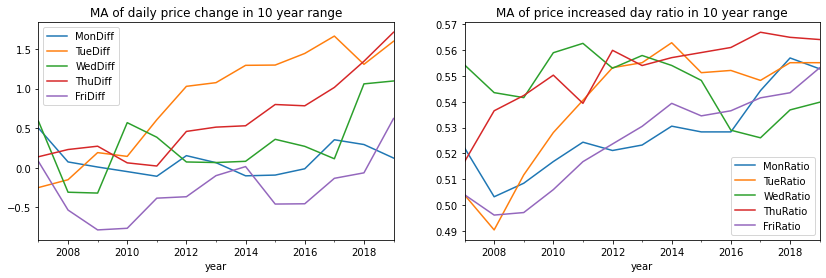

In [10]:
y_range = 10
tdw_10ma = create_tdw_data_of(y_range, dfy)

# 各曜日の（終値 - 始値）の移動平均と、上昇日の割合をプロット
fig, ax = plt.subplots(1, 2, figsize=(14,4))
tdw_10ma[['MonDiff', 'TueDiff', 'WedDiff', 'ThuDiff', 'FriDiff']].plot(ax=ax[0])
tdw_10ma[['MonRatio', 'TueRatio', 'WedRatio', 'ThuRatio', 'FriRatio']].plot(ax=ax[1])
ax[0].set_title(f'MA of daily price change in {y_range} year range')
ax[1].set_title(f'MA of price increased day ratio in {y_range} year range')

## 5年間の移動平均

Text(0.5, 1.0, 'MA of price increased day ratio in 5 year range')

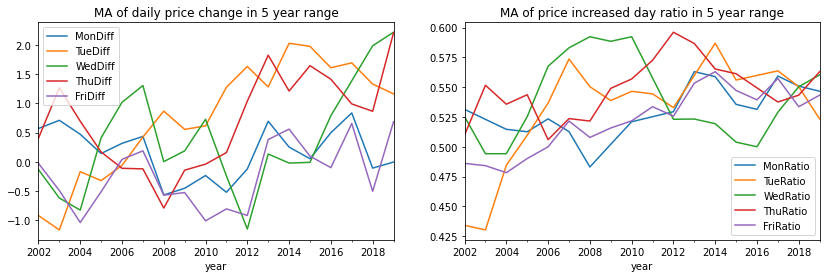

In [11]:
y_range = 5
tdw_5ma = create_tdw_data_of(y_range, dfy)

# 各曜日の（終値 - 始値）の移動平均と、上昇日の割合をプロット
fig, ax = plt.subplots(1, 2, figsize=(14,4))
tdw_5ma[['MonDiff', 'TueDiff', 'WedDiff', 'ThuDiff', 'FriDiff']].plot(ax=ax[0])
tdw_5ma[['MonRatio', 'TueRatio', 'WedRatio', 'ThuRatio', 'FriRatio']].plot(ax=ax[1])
ax[0].set_title(f'MA of daily price change in {y_range} year range')
ax[1].set_title(f'MA of price increased day ratio in {y_range} year range')

## 1年間の移動平均

Text(0.5, 1.0, 'MA of price increased day ratio in 1 year range')

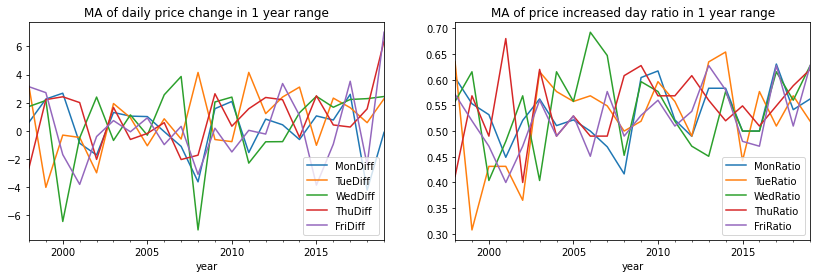

In [12]:
y_range = 1
tdw_1ma = create_tdw_data_of(y_range, dfy)

# 各曜日の（終値 - 始値）の移動平均と、上昇日の割合をプロット
fig, ax = plt.subplots(1, 2, figsize=(14,4))
tdw_1ma[['MonDiff', 'TueDiff', 'WedDiff', 'ThuDiff', 'FriDiff']].plot(ax=ax[0])
tdw_1ma[['MonRatio', 'TueRatio', 'WedRatio', 'ThuRatio', 'FriRatio']].plot(ax=ax[1])
ax[0].set_title(f'MA of daily price change in {y_range} year range')
ax[1].set_title(f'MA of price increased day ratio in {y_range} year range')

# 移動平均値の平均に曜日間で差があるかを統計的に判断する

## 10年移動平均で検定

In [13]:
# 単純に各曜日のデータ間で分散分析してみる
# そのためにまず可視化
# 1年間の移動平均データを使う
columns = ['CODiff', 'IncRatio', 'period', 'day']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
tdw10 = pd.DataFrame(columns=columns)
for day in days:
    df_tmp = tdw_10ma.loc[:, [f'{day}Diff', f'{day}Ratio', 'period']]
    df_tmp['day'] = [day] * df_tmp.shape[0]
    df_tmp.columns = columns
    tdw10 = tdw10.append(df_tmp)
day_type = CategoricalDtype(categories=days, ordered=True)
tdw10['day'] = tdw10['day'].astype(day_type)
tdw10 = tdw10.reset_index()
tdw10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     65 non-null     datetime64[ns]
 1   CODiff    65 non-null     float64       
 2   IncRatio  65 non-null     float64       
 3   period    65 non-null     object        
 4   day       65 non-null     category      
dtypes: category(1), datetime64[ns](1), float64(2), object(1)
memory usage: 2.4+ KB


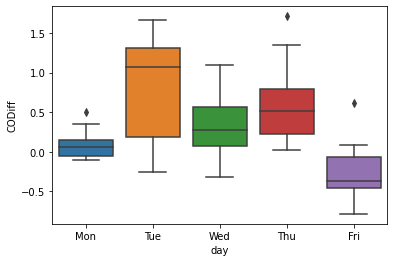

In [14]:
# この各群（各曜日データ）の平均値の間に有意な差がみられるかを分散分析で検定する
sns.boxplot('day', 'CODiff', data=tdw10)

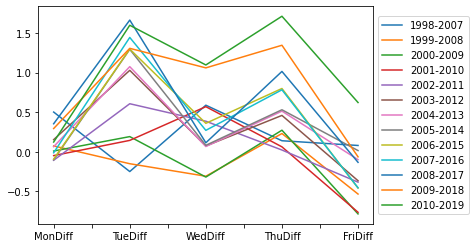

In [15]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
# 対応有りなら、上記の箱ひげ図ではなく、「対応」を線で結んだ以下のプロットのほうが適切だろう
tdw10t = tdw_10ma.set_index('period')
tdw10t = tdw10t.T
tdw10t_diff = tdw10t.loc[['MonDiff', 'TueDiff', 'WedDiff', 'ThuDiff', 'FriDiff'], :]
tdw10t_ratio = tdw10t.loc[['MonRatio', 'TueRatio', 'WedRatio', 'ThuRatio', 'FriRatio'], :]
tdw10t_diff.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [16]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
aov = anova.AnovaRM(tdw10, 'CODiff','period',['day'])
result10 = aov.fit()
print(result10)

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day 19.3230 4.0000 48.0000 0.0000



In [17]:
# 有意な差がみられたので、多重検定でどの群の平均値が他の群と異なるか検定
print(pairwise_tukeyhsd(tdw10['CODiff'], tdw10['day']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   Fri    Mon   0.3486 0.3271 -0.1667  0.8639  False
   Fri    Thu   0.8614  0.001  0.3461  1.3767   True
   Fri    Tue   1.1199  0.001  0.6046  1.6352   True
   Fri    Wed   0.5657 0.0245  0.0504   1.081   True
   Mon    Thu   0.5128 0.0518 -0.0025  1.0281  False
   Mon    Tue   0.7713  0.001   0.256  1.2866   True
   Mon    Wed   0.2171 0.7339 -0.2982  0.7324  False
   Thu    Tue   0.2585 0.6079 -0.2568  0.7738  False
   Thu    Wed  -0.2956 0.4947 -0.8109  0.2197  False
   Tue    Wed  -0.5542  0.029 -1.0695 -0.0389   True
----------------------------------------------------


## 1年移動平均で検定

In [18]:
# 単純に各曜日のデータ間で分散分析してみる
# そのためにまず可視化
# 1年間の移動平均データを使う
columns = ['CODiff', 'IncRatio', 'period', 'day']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
tdw1 = pd.DataFrame(columns=columns)
for day in days:
    df_tmp = tdw_1ma.loc[:, [f'{day}Diff', f'{day}Ratio', 'period']]
    df_tmp['day'] = [day] * df_tmp.shape[0]
    df_tmp.columns = columns
    tdw1 = tdw1.append(df_tmp)
#tdw1 = tdw1.append(pd.Data)
#tdw_1ma.head(3)
day_type = CategoricalDtype(categories=days, ordered=True)
tdw1['day'] = tdw1['day'].astype(day_type)
tdw1 = tdw1.reset_index()
tdw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     110 non-null    datetime64[ns]
 1   CODiff    110 non-null    float64       
 2   IncRatio  110 non-null    float64       
 3   period    110 non-null    object        
 4   day       110 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(2), object(1)
memory usage: 3.9+ KB


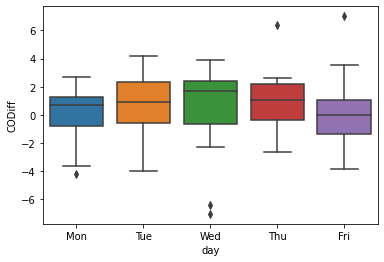

In [19]:
# この各群（各曜日データ）の平均値の間に有意な差がみられるかを分散分析で検定する
sns.boxplot('day', 'CODiff', data=tdw1)

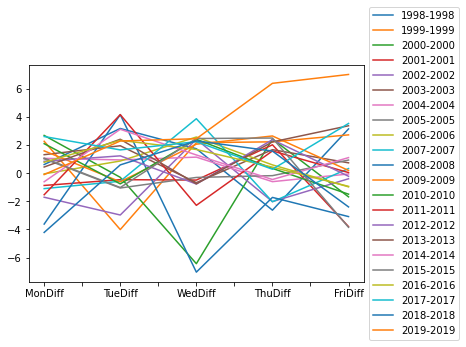

In [20]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
# 対応有りなら、上記の箱ひげ図ではなく、「対応」を線で結んだ以下のプロットのほうが適切だろう
tdw1t = tdw_1ma.set_index('period')
tdw1t = tdw1t.T
tdw1t_diff = tdw1t.loc[['MonDiff', 'TueDiff', 'WedDiff', 'ThuDiff', 'FriDiff'], :]
tdw1t_ratio = tdw1t.loc[['MonRatio', 'TueRatio', 'WedRatio', 'ThuRatio', 'FriRatio'], :]
tdw1t_diff.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [21]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
aov = anova.AnovaRM(tdw1, 'CODiff','period',['day'])
result1 = aov.fit()
print(result1)

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  0.4512 4.0000 84.0000 0.7712



## 上昇日割合の平均に曜日間で差があるかを統計的に判断する
要するに、TDWのみでデイトレード（始値で買って終値で売る戦略の理想的な状況）をした時の勝率の移動平均

## 10年移動平均で検定

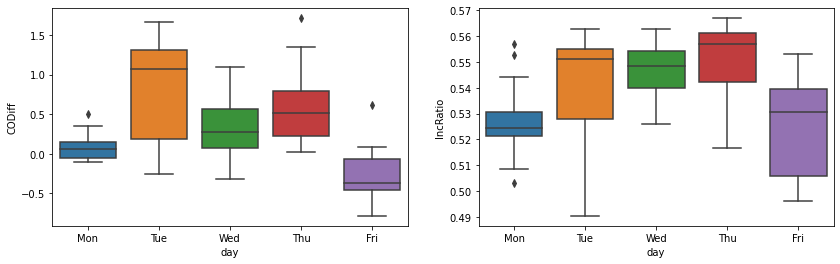

In [23]:
# この各群（各曜日データ）の平均値の間に有意な差がみられるかを分散分析で検定する
# 両方見たいので、値動きと上昇日割合を両方プロット
# 以下、検定するのは右のプロット
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.boxplot('day', 'CODiff', data=tdw10, ax=ax[0])
sns.boxplot('day', 'IncRatio', data=tdw10, ax=ax[1])

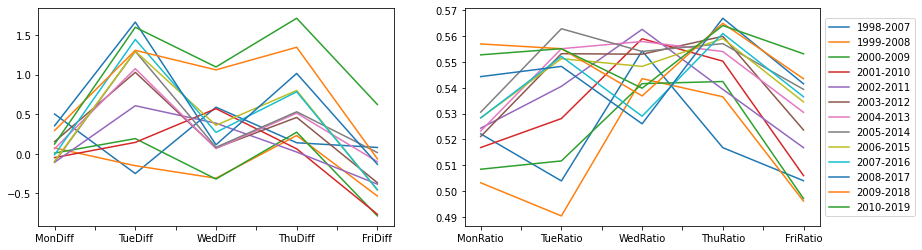

In [26]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
# 対応有りなら、上記の箱ひげ図ではなく、「対応」を線で結んだ以下のプロットのほうが適切だろう
# ここでも、左に値動き、右に上昇日割合のプロットをする
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
tdw10t_diff.plot(legend=False, ax=ax[0])
tdw10t_ratio.plot(ax=ax[1]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [27]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
aovr = anova.AnovaRM(tdw10, 'IncRatio','period',['day'])
result10r = aovr.fit()
print(result10r)

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day 10.3487 4.0000 48.0000 0.0000



In [28]:
# 有意な差がみられたので、多重検定でどの群の平均値が他の群と異なるか検定
print(pairwise_tukeyhsd(tdw10['IncRatio'], tdw10['day']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   Fri    Mon   0.0029    0.9 -0.0161  0.022  False
   Fri    Thu   0.0269 0.0017  0.0079  0.046   True
   Fri    Tue   0.0142 0.2319 -0.0048 0.0333  False
   Fri    Wed   0.0218  0.017  0.0028 0.0408   True
   Mon    Thu    0.024 0.0066   0.005 0.0431   True
   Mon    Tue   0.0113 0.4592 -0.0077 0.0304  False
   Mon    Wed   0.0189 0.0528 -0.0001 0.0379  False
   Thu    Tue  -0.0127 0.3422 -0.0317 0.0063  False
   Thu    Wed  -0.0051    0.9 -0.0242 0.0139  False
   Tue    Wed   0.0076 0.7716 -0.0115 0.0266  False
---------------------------------------------------


## 1年移動平均で検定

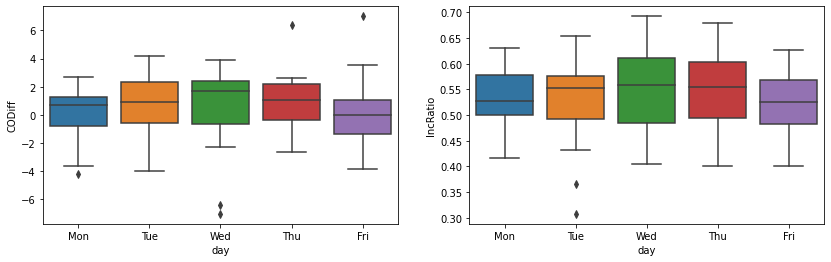

In [29]:
# この各群（各曜日データ）の平均値の間に有意な差がみられるかを分散分析で検定する
# 両方見たいので、値動きと上昇日割合を両方プロット
# 以下、検定するのは右のプロット
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.boxplot('day', 'CODiff', data=tdw1, ax=ax[0])
sns.boxplot('day', 'IncRatio', data=tdw1, ax=ax[1])

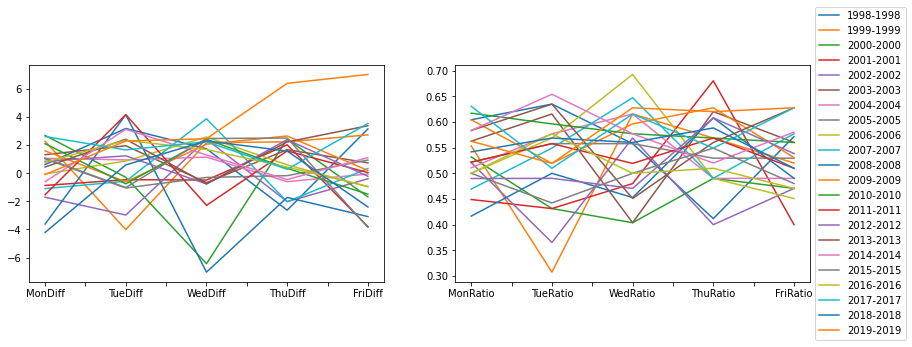

In [30]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
# 対応有りなら、上記の箱ひげ図ではなく、「対応」を線で結んだ以下のプロットのほうが適切だろう
# ここでも、左に値動き、右に上昇日割合のプロットをする
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
tdw1t_diff.plot(legend=False, ax=ax[0])
tdw1t_ratio.plot(ax=ax[1]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [31]:
# 対応有りの1元配置分散分析で曜日間に平均値の差があるかどうか検定する
# 各平均値は特定の年に対応するため、「対応有り」とする
aov1r = anova.AnovaRM(tdw1, 'IncRatio','period',['day'])
result1r = aov1r.fit()
print(result1r)

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  0.4443 4.0000 84.0000 0.7762



## そもそも移動平均などとらず、生のデータでそのまま検定するべきだ

In [36]:
# 曜日ごとで値動き（終値 - 始値）の平均値に差があるかを対応なし1元配置分散分析で検定
mon_diff = df[df['Day'] == 'Mon']['CODiff']
tue_diff = df[df['Day'] == 'Tue']['CODiff']
wed_diff = df[df['Day'] == 'Wed']['CODiff']
thu_diff = df[df['Day'] == 'Thu']['CODiff']
fri_diff = df[df['Day'] == 'Fri']['CODiff']
f, p = st.f_oneway(mon_diff, tue_diff, wed_diff, thu_diff, fri_diff)
print(f"F = {f}, p-value = {p}")

F = 0.389139811613096, p-value = 0.8165669137329328
